## Logistic Regression

Logistic Regression is a model to predict the probability of a CATEGORICAL target.

The target variable can be:
* Binary: yes or no (0 or 1)
* Multi-nomial: more then 2 options, without hierarchy (i.e.:cat, dog and mouse)
* Ordinal: more then 2 options, with hierarchy (i.e.: rating from 1 to 5)

Don't forget the [DOCS](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). <br>
More on formulas and functions [here](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc). <br>
Why accuracy score is not the best metric? [here](https://stats.stackexchange.com/questions/312780/why-is-accuracy-not-the-best-measure-for-assessing-classification-models). <br>
### Awesome resource to understand Logistic Regression [here](https://www.youtube.com/watch?v=yIYKR4sgzI8&list=PLblh5JKOoLUKxzEP5HA2d-Li7IJkHfXSe)

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

import getpass  # to get the password without showing the input
password = getpass.getpass()

connection_string = 'mysql+pymysql://root:' + password + '@localhost/bank'
engine = create_engine(connection_string)

 ·····


Now we want to develop a classification model to predict the status of the customer based on the information available.

In [2]:
query = '''SELECT t.type, t.operation, t.amount AS t_amount, t.balance, t.k_symbol, l.amount AS l_amount, l.duration, l.payments, l.status
           FROM trans t
           LEFT JOIN loan l
           ON t.account_id = l.account_id
           WHERE l.status IN ('A', 'B');'''

data = pd.read_sql_query(query, engine)
data

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,PREVOD Z UCTU,44749.0,45549.0,,79608,24,3317.0,A
1,PRIJEM,VKLAD,1000.0,1000.0,,52788,12,4399.0,A
2,PRIJEM,VKLAD,1100.0,1100.0,,21924,36,609.0,A
3,PRIJEM,VKLAD,700.0,700.0,,23052,12,1921.0,A
4,PRIJEM,VKLAD,900.0,900.0,,41904,12,3492.0,A
...,...,...,...,...,...,...,...,...,...
74359,PRIJEM,,221.3,48019.4,UROK,131292,36,3647.0,A
74360,PRIJEM,,227.6,108432.0,UROK,168984,24,7041.0,B
74361,PRIJEM,,235.7,53703.3,UROK,182628,36,5073.0,A
74362,PRIJEM,,293.0,85131.6,UROK,274740,60,4579.0,A


In [3]:
data.shape, data.dtypes

((74364, 9),
 type          object
 operation     object
 t_amount     float64
 balance      float64
 k_symbol      object
 l_amount       int64
 duration       int64
 payments     float64
 status        object
 dtype: object)

In [24]:
data.isna().sum()

type         0
operation    0
t_amount     0
balance      0
k_symbol     0
l_amount     0
duration     0
payments     0
status       0
dtype: int64

In [25]:
data.describe()

,t_amount,balance,l_amount,duration,payments
count,74364.000000,74364.000000,74364.000000,74364.000000,74364.000000
mean,7832.649125,46022.153061,102745.132645,23.942230,4356.580832
std,11729.040391,25439.948570,74749.275498,12.155783,2205.840892
min,0.000000,-14137.200000,4980.000000,12.000000,319.000000
25%,144.300000,27675.125000,46320.000000,12.000000,2569.000000
50%,3000.000000,40965.150000,86184.000000,24.000000,4051.000000
75%,9868.500000,60098.550000,140400.000000,36.000000,6315.000000
max,87300.000000,193910.000000,464520.000000,60.000000,9736.000000


In [6]:
for col in data.select_dtypes('object'):
    print(data[col].value_counts(), '\n') #unique()

VYDAJ     44075
PRIJEM    27660
VYBER      2629
Name: type, dtype: int64 

VYBER             34667
                  14646
PREVOD NA UCET    11647
VKLAD             10525
PREVOD Z UCTU      2489
VYBER KARTOU        390
Name: operation, dtype: int64 

               35953
UROK           14646
SLUZBY         11306
SIPO            5081
                3018
UVER            2893
POJISTNE        1159
SANKC. UROK      308
Name: k_symbol, dtype: int64 

A    64599
B     9765
Name: status, dtype: int64 



In [74]:
# if you want to filter them out instead of cleaning
# data[(data['k_symbol'] != '') & (data['k_symbol'] != ' ') & (data['operation'] != ' ')] 

In [26]:
def clean_empty(x):
    return 'UNK' if x == '' or x == ' ' else x

# it's the same as this:
def clean_empty(x):
    if x == '' or x == ' ':
        return 'UNK' 
    else:
        return x
    
# or with lambda
lmd = lambda x: 'UNK' if x == '' or x == ' ' else x

In [27]:
# with regular apply - gets all values row wise OR column wise (axis parameter)
for col in data.select_dtypes('object'):
    data[col] = data[col].apply(clean_empty) # lmb

In [28]:
# with applymap - gets every value (row AND column wise)
data.applymap(clean_empty) # lmb

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments,status
0,PRIJEM,PREVOD Z UCTU,44749.0,45549.0,UNK,79608,24,3317.0,A
1,PRIJEM,VKLAD,1000.0,1000.0,UNK,52788,12,4399.0,A
2,PRIJEM,VKLAD,1100.0,1100.0,UNK,21924,36,609.0,A
3,PRIJEM,VKLAD,700.0,700.0,UNK,23052,12,1921.0,A
4,PRIJEM,VKLAD,900.0,900.0,UNK,41904,12,3492.0,A
...,...,...,...,...,...,...,...,...,...
74359,PRIJEM,UNK,221.3,48019.4,UROK,131292,36,3647.0,A
74360,PRIJEM,UNK,227.6,108432.0,UROK,168984,24,7041.0,B
74361,PRIJEM,UNK,235.7,53703.3,UROK,182628,36,5073.0,A
74362,PRIJEM,UNK,293.0,85131.6,UROK,274740,60,4579.0,A


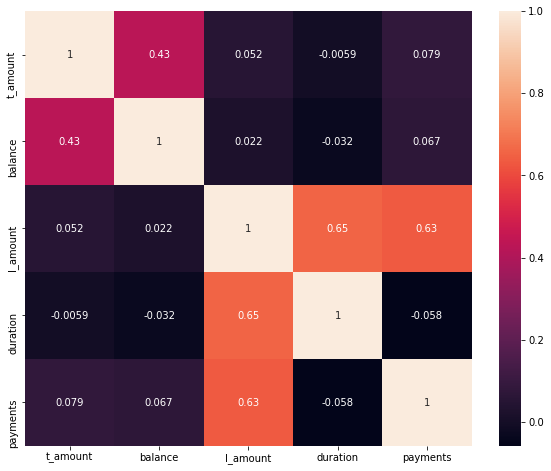

In [29]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

/Users/abhimanyumittal/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


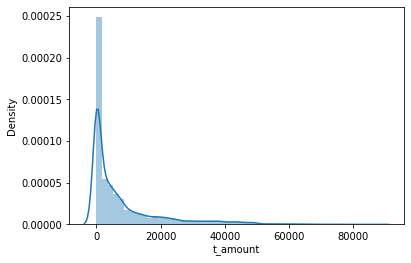

/Users/abhimanyumittal/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


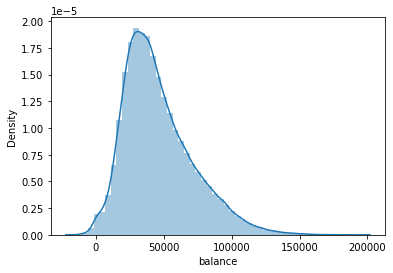

/Users/abhimanyumittal/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


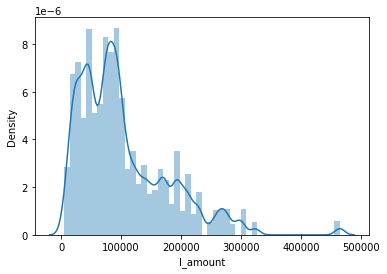

/Users/abhimanyumittal/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


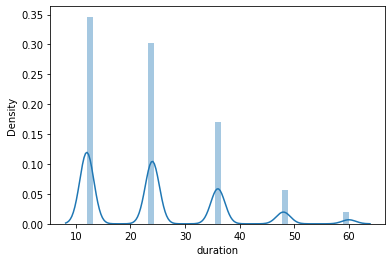

/Users/abhimanyumittal/venv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


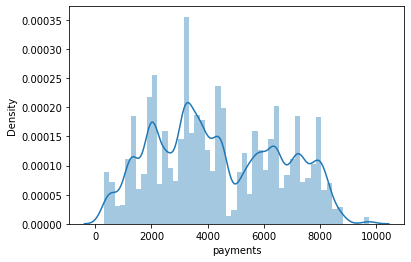

In [30]:
for col in data.select_dtypes(np.number):
    sns.distplot(data[col])
    plt.show()

In [31]:
y = data['status']
X = data.drop('status', axis=1)

In [33]:
X

,type,operation,t_amount,balance,k_symbol,l_amount,duration,payments
0,PRIJEM,PREVOD Z UCTU,44749.0,45549.0,UNK,79608,24,3317.0
1,PRIJEM,VKLAD,1000.0,1000.0,UNK,52788,12,4399.0
2,PRIJEM,VKLAD,1100.0,1100.0,UNK,21924,36,609.0
3,PRIJEM,VKLAD,700.0,700.0,UNK,23052,12,1921.0
4,PRIJEM,VKLAD,900.0,900.0,UNK,41904,12,3492.0
...,...,...,...,...,...,...,...,...
74359,PRIJEM,UNK,221.3,48019.4,UROK,131292,36,3647.0
74360,PRIJEM,UNK,227.6,108432.0,UROK,168984,24,7041.0
74361,PRIJEM,UNK,235.7,53703.3,UROK,182628,36,5073.0
74362,PRIJEM,UNK,293.0,85131.6,UROK,274740,60,4579.0


In [34]:
X = pd.get_dummies(X, columns=['type', 'operation', 'k_symbol'])
X

,t_amount,balance,l_amount,duration,payments,type_PRIJEM,type_VYBER,type_VYDAJ,operation_PREVOD NA UCET,operation_PREVOD Z UCTU,...,operation_VKLAD,operation_VYBER,operation_VYBER KARTOU,k_symbol_POJISTNE,k_symbol_SANKC. UROK,k_symbol_SIPO,k_symbol_SLUZBY,k_symbol_UNK,k_symbol_UROK,k_symbol_UVER
0,44749.0,45549.0,79608,24,3317.0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,1000.0,1000.0,52788,12,4399.0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1100.0,1100.0,21924,36,609.0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
3,700.0,700.0,23052,12,1921.0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,900.0,900.0,41904,12,3492.0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74359,221.3,48019.4,131292,36,3647.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
74360,227.6,108432.0,168984,24,7041.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
74361,235.7,53703.3,182628,36,5073.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
74362,293.0,85131.6,274740,60,4579.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [58]:
y.value_counts(normalize=True)

A    0.868686
B    0.131314
Name: status, dtype: float64

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
len(X_test), len(X_train), len(y_train), len(y_test)

(14873, 59491, 59491, 14873)

In [52]:
classification = LogisticRegression(random_state=42, max_iter=1000)

classification.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [53]:
classification.score(X_test, y_test) # checking the score without the need for predictions
# 0.8729913265649163

0.8729913265649163

In [44]:
# X_test -> 100
# correct_pred -> 80

75

In [17]:
# to get predictions
predictions = classification.predict(X_test)
predictions

array(['A', 'A', 'A', ..., 'A', 'A', 'A'], dtype=object)

In [18]:
y_test

27359    A
14664    A
4361     A
41905    A
19821    B
        ..
6111     B
46494    A
52842    A
23300    A
21617    A
Name: status, Length: 14873, dtype: object

In [54]:
# to get the probability instead
predictions_ = classification.predict_proba(X_test)
predictions_

array([[0.95279426, 0.04720574],
       [0.94907554, 0.05092446],
       [0.91842873, 0.08157127],
       ...,
       [0.78223812, 0.21776188],
       [0.88288291, 0.11711709],
       [0.5390144 , 0.4609856 ]])

In [20]:
confusion_matrix(y_test, predictions) # normalize : {'true', 'pred', 'all'}

array([[12680,   155],
       [ 1734,   304]])

From DOC:

    Confusion matrix whose i-th row and j-th
    column entry indicates the number of
    samples with true label being i-th class
    and predicted label being j-th class.

![](https://miro.medium.com/max/664/1*M295_PhlqBaq_SFj7edQ5w.png)

In [55]:
cf_matrix = confusion_matrix(y_test, predictions, normalize='all')
cf_matrix

array([[0.8525516 , 0.01042157],
       [0.1165871 , 0.02043972]])

<AxesSubplot:>

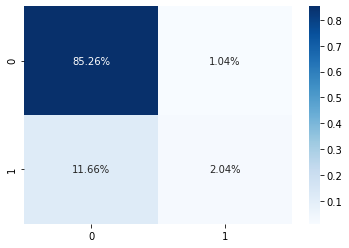

In [23]:
sns.heatmap(cf_matrix, annot=True, fmt='.2%', cmap='Blues')

<AxesSubplot:>

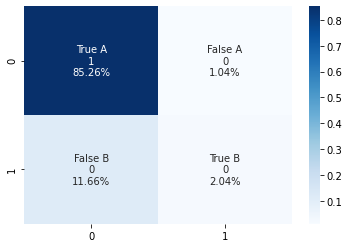

In [171]:
group_names = ['True A', 'False A', 'False B', 'True B']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')